# Bias v.s. Variance

The objective of the following exercise is to explore the relationship between two competing properties of a statistical learning model: *variance* and *bias*. 

The *Variance* consists in the amount by which a model changes when we train it on a different data set. It is expected that the fitted method varies according to the data it is fed with, nevertheless the change shouldn't be significant. If this is not the case the model is generally too flexible and is said to have high variance.

On the other hand, the Bias is the error introduced when we try to model a real world problem, which may be very complicated, with a too simple approximation. In the example below we try to predict the water flowing out of a dam using the change in water level of an external reservoir. It is immediately clear that the relation between X and y is not linear. Nevertheless, for the purpose of experimenting with ML we'll fit a linear model and check the results we get. Evidently the method poorly estimates the true relationship between X and y. In this case, a linear model is said to have high bias.

As a general rule, the more we increase the flexibity of a method, the more the variance increases and the bias decreases. The rate at which the two properties change is not the same though and it is crucial to study their relative fluctuation to find the sweet spot minimizing the total model error. 

### The water and the dam

As announced above we will build a predictive model to forecast the amount of water getting out of a dam. We'll do this playing around with Linear Regression. At first drawing a straight line and later on extending the feature space with the addition of p-th degree polynomials of X.

First recall the regularized cost function and its gradient for Linear Regression:

$J(\theta) = \frac{1}{2m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)})^2 + \frac{\lambda}{2m}\sum_{j=1}^n\theta_j^2$

$\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)} $ for $j=0$

$\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)} + \frac{\lambda}{m}\sum_{j=1}^n\theta_j$ for $j\geq1$

where $\lambda$ is a regularization parameter which controls the degree of regularization (thud, help preventing overfitting). The regularization term puts a penalty on the overall cost $J$. As the magnitudes of the model parameters $\theta_j$ increase, the penalty increases as well.
Let's explore this dataset more in detail and check the effects of various models on it.

## Univariate Linear Regression - High Bias, Low Variance

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
from scipy import optimize

In [316]:
mat = scipy.io.loadmat('ex5data1.mat')
X = mat['X']
y = mat['y']
X_val = mat['Xval']
y_val = mat['yval']
X_test = mat['Xtest']
y_test = mat['ytest']

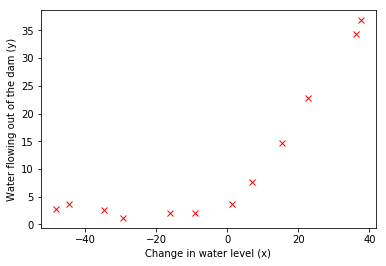

In [70]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 
ax.plot(X, y, 'x', color='r')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.show()

### Functions

In [315]:
def costFunctionReg(theta, X, y, lamda):
    m = y.shape[0]
    h_y = X.dot(theta) - y
    #theta[0] = 0
    cost = (1/(2*m)) * (sum(h_y**2)) + (lamda/(2*m))*(sum(theta[1:]**2))
    return cost

def computeGradientReg(theta, X, y, lamda):
    theta = theta.reshape(-1, 1)
    m = y.shape[0]
    h_y = X.dot(theta) - y
    #theta[0] = 0
    grad = 1/m * (h_y).T.dot(X)
    grad[1:] = grad + lamda/m*theta[1:].T
    return grad

def gradientDescent(X, y, theta, alpha, num_iters, lamda):
    m = y.shape[0]
    J_history = np.zeros((num_iters, 1))
    for i in range(num_iters):
        h_y = X.dot(theta) - y
        gradient = (alpha/m)*((X.T).dot(h_y))
        gradient[1:] = gradient[1:] + (lamda/m*theta[1:])
        theta = theta - gradient
        J_history[i] = costFunctionReg(theta, X, y, lamda)
       
    return theta, J_history

In [317]:
X = np.c_[np.ones(X.shape[0]), X]

In [318]:
lamda = 1
initial_theta = np.ones((X.shape[1], 1))
cost = costFunctionReg(initial_theta, X, y, lamda)
gradient = computeGradientReg(initial_theta, X, y, lamda)
print('Cost with theta = [1,1] and lambda = 1: ', cost)
print('Gradient of cost with theta = [1,1] and lambda = 1:', grad)

Cost with theta = [1,1] and lambda = 1:  [303.99319222]
Gradient of cost with theta = [1,1] and lambda = 1: [-15.30301567 598.25074417]


In [319]:
lamda = 0
initial_theta = np.ones((X.shape[1], 1))
num_iters = 3000
alpha = 0.001
theta, J_history = gradientDescent(X, y, initial_theta, alpha, num_iters, lamda)
print("Theta found by gradient descent: intercept={0}, slope={1}".format(theta_opt[0],theta_opt[1]))

Theta found by gradient descent: intercept=[12.42957875], slope=[0.36383098]


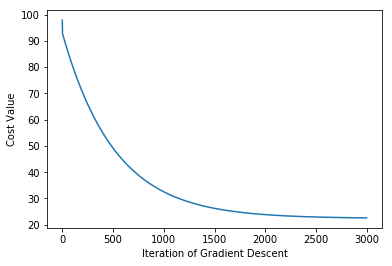

In [320]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(num_iters), j)
plt.ylabel('Cost Value')
plt.xlabel('Iteration of Gradient Descent')
plt.show()

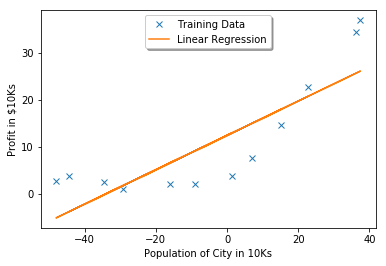

In [321]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 
ax.plot(X[:, 1], y[:, 0], 'x', label='Training Data')
ax.plot(X[:,1], np.matmul(X, theta), linestyle='-', label='Linear Regression')
# set the legend for the labels: 'Training Data' and 'Linear Regression'
legend = ax.legend(loc='upper center', shadow=True)
plt.ylabel('Change in water level (x)')
plt.xlabel('Water flowing out of the dam (y)')
plt.show()

In [324]:
from scipy import optimize
theta = optimize.minimize(fun=costFunctionReg, x0=initial_theta.squeeze(), args=(X, y, lamda),
                                  method='TNC', jac=computeGradientReg, options=dict(disp=True, maxiter=100000))


ValueError: tnc: invalid return value from minimized function.